<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/Noise_Cancellation_Using_NNFWI_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full-Waveform Inversion using GAN with LSTM

This Colab notebook implements a Full-Waveform Inversion (FWI) model using a Generative Adversarial Network (GAN) combined with LSTM layers. The generator network is designed to produce inverse waveforms, while the discriminator ensures the quality of the generated waveforms. The approach is based on the paper "Integrating Deep Neural Networks with Full-waveform Inversion: Reparametrization, Regularization, and Uncertainty Quantification" ([arXiv:2012.11149](https://arxiv.org/pdf/2012.11149.pdf)).

In [2]:
## 1. Install Required Libraries
!pip install tensorflow librosa matplotlib

In [3]:
## 2. Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
import librosa
import numpy as np
import matplotlib.pyplot as plt

Saving 5-9032-A-0.wav to 5-9032-A-0.wav
Shape of downsampled x_train: (1, 22050, 1)


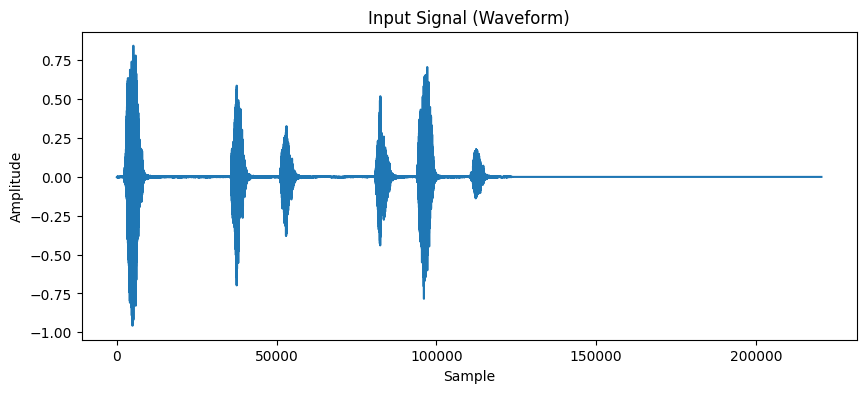

In [4]:
## 3. Load the Input Waveform (.wav file)
# You can upload your own .wav file, or use a synthetic one.
from google.colab import files
uploaded = files.upload()

audio_path = list(uploaded.keys())[0]
y, sr = librosa.load(audio_path, sr=None)

# Downsample the input waveform to reduce the sequence length
target_sr = sr // 10  # Downsample by a factor of 10
y_downsampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

# Reshape the downsampled waveform for the LSTM
x_train = y_downsampled.reshape((1, len(y_downsampled), 1))
print(f"Shape of downsampled x_train: {x_train.shape}")

# Now use the same model for training with the downsampled data



# Plot the input signal
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title('Input Signal (Waveform)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [5]:
## 4. Define the Generator Network
# The generator network will learn to generate the inverse waveform

def build_generator():
    inputs = tf.keras.layers.Input(shape=(None, 1))  # Explicit input layer
    x = LSTM(64, return_sequences=True, recurrent_activation='sigmoid', recurrent_dropout=0.3, use_bias=True, unroll=False, use_cudnn=False)(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=True, recurrent_activation='sigmoid', recurrent_dropout=0.3, use_bias=True, unroll=False, use_cudnn=False)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='linear')(x)  # Linear output for waveform prediction
    return tf.keras.Model(inputs, outputs)  # Return the model

#def build_generator():
#    inputs = tf.keras.layers.Input(shape=(None, 1))  # Explicit input layer
#    x = LSTM(64, return_sequences=True)(inputs)
#    x = Dropout(0.3)(x)
#    x = LSTM(128, return_sequences=True)(x)  # Keep return_sequences=True
#    x = Dropout(0.3)(x)
#    outputs = Dense(1, activation='linear')(x)  # Output a sequence with the same length as input
#    return tf.keras.Model(inputs, outputs)

generator = build_generator()

# Summary of the Generator
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 64)            │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 1)             │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,841 (452.50 KB)

 Trainable params: 115,841 (452.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
## 5. Define the Discriminator Network
# The discriminator will try to distinguish between real and generated waveforms
#def build_discriminator():
#    inputs = tf.keras.layers.Input(shape=(1,))  # Explicit input layer
#    x = Dense(64, activation='relu')(inputs)
#    outputs = Dense(1, activation='sigmoid')(x)  # Output probability (real/fake)
#    return tf.keras.Model(inputs, outputs)  # Return the model

def build_discriminator():
    inputs = tf.keras.layers.Input(shape=(None, 1))  # Accept sequences of any length
    x = tf.keras.layers.Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)  # Pooling to reduce dimensionality
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Output a probability (real/fake)
    return tf.keras.Model(inputs, outputs)


discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the Discriminator
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,281 (130.00 KB)

 Trainable params: 33,281 (130.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
## 6. GAN Model
# The GAN model will train the generator and the discriminator
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

gan = build_gan(generator, discriminator)

In [8]:
## 7. Preprocess the Data
# Reshape input signal to be compatible with LSTM
x_train = y.reshape((1, len(y), 1))  # (Batch, Time steps, Features)
y_train = np.ones((1, 1))  # Label (real signal)

In [9]:
## 8. Train the GAN
epochs = 5000
for epoch in range(epochs):
    # Ensure that input data is correctly shaped and typed
    x_train = x_train.astype(np.float32)
    y_train = y_train.astype(np.float32)

    # Train the discriminator
    try:
        generated_waveform = generator.predict(x_train)
        print(f"Generated waveform shape: {generated_waveform.shape}")

        # Now, real_waveform is the same shape as x_train (no reshaping needed)
        real_waveform = y.reshape((1, len(y), 1))  # Real waveform with same shape

        d_loss_real = discriminator.train_on_batch(real_waveform, y_train)
        d_loss_fake = discriminator.train_on_batch(generated_waveform, np.zeros((1, 1)))

        # Train the generator
        g_loss = gan.train_on_batch(x_train, np.ones((1, 1)))

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Discriminator Loss: Real {d_loss_real}, Fake {d_loss_fake}, Generator Loss: {g_loss}")

    except Exception as e:
        print(f"Error during epoch {epoch}: {str(e)}")
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Generated waveform shape: (1, 220500, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Error during epoch 0: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/pytho

In [ ]:
## 9. Generate the Inverse Waveform
inverse_waveform = generator.predict(x_train).flatten()

# Plot the inverse waveform
plt.figure(figsize=(10, 4))
plt.plot(inverse_waveform)
plt.title('Inverse Waveform Generated by GAN')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
## 10. Combine Input and Inverse Signals
combined_signal = y + inverse_waveform

# Plot the combined signal
plt.figure(figsize=(10, 4))
plt.plot(combined_signal)
plt.title('Combined Signal (Input + Inverse)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
## 11. Visualize the Residual (Difference between Input and Combined)
residual = np.abs(y - combined_signal)
plt.figure(figsize=(10, 4))
plt.plot(residual)
plt.title('Residual (Input - Combined)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

## Conclusion
- The GAN model with LSTM layers is used to generate an inverse waveform.
- By combining the generated waveform with the input signal, we aim to cancel the input signal.
- The residual plot shows the difference between the input signal and the combined result.

### Reference:
- Physics-Informed Neural Networks for Full-Waveform Inversion ([arXiv:2012.11149](https://arxiv.org/pdf/2012.11149.pdf))